In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
import cmath as cm
import pathlib
from numpy.ma.core import shape

sys.path.insert(0, '/Users/sam/PycharmProjects/Quantum-Control/NewModule')
from arc_sam import *  # Import ARC (Alkali Rydberg Calculator)

atom = Calcium40()
calc = StarkMap(atom)

n = 35
l = 3
j = 3
mj = 0
s = 0
nmin = n - 3
nmax = n + 3
lmax = nmax - 1

"""
Rappel des unités atomiques  :
action : hbar = 1 , hbar = 1.1*10^-34 J.s
energie : hartree, 1 Hartree = 4.359*10^-18 J
temps : 1 t.ua = 2.418*10^-17 s
champ électrique : 1 ce.ua = 5.14*10^11V/m

"""
conv_en = 4.359e18
conv_t = 2.418e17
conv_ce = 5.14e-11
hbar = 1
calc.defineBasis(n,l,j,mj,nmin,nmax,lmax,s=s, progressOutput=True)
def U(en,dt):
    """
    arg : en : is the energy of the level considered.
    arg : dt : is the time step.
    result : time evolution operator of the level considered, it's a phase on the WaveFunction.

    in this code, the U operator will be used in two cases.
    First evolution when there is no field applied -> U must takes the energy of the atomic level
    When the field is applied -> U must take the energy of the considered Stark level

    """
    u = cm.exp(0 - 1j*en*dt/hbar)
    return u
def apply_pulse(psi_in, pulse):
    psi_out = np.zeros(len(psi_in), dtype=np.complex128)
    """
    Probably better to do the conv_to_ua in the U fonction

    :arg psi_in: wavefunction before the pulse
    :arg pulse: list of 2 elts, pulse amplitude in V/m and pulse duration in s
    :return psi_out: wavefunction after the pulse

    """
    if pulse.stark:
        # Transformation vers la base Stark
        psi_stark = np.zeros(len(psi_in), dtype=np.complex128)
        for stark_state_idx in range(len(psi_in)):
            # Calcul de la composante Stark
            for atomic_comp in calc.composition[pulse.index_of_amplitude()][stark_state_idx]:
                atomic_idx = atomic_comp[1]
                coeff = atomic_comp[0]
                psi_stark[stark_state_idx] += coeff * psi_in[atomic_idx]
        
        # Évolution temporelle dans la base Stark
        for stark_state_idx in range(len(psi_stark)):
            en = calc.y[pulse.index_of_amplitude()][stark_state_idx] * conv_en
            psi_stark[stark_state_idx] *= U(en, pulse.duration * conv_t)
        
        # Retour à la base atomique
        for atomic_idx in range(len(psi_in)):
            for stark_state_idx in range(len(psi_stark)):
                for comp in calc.composition[pulse.index_of_amplitude()][stark_state_idx]:
                    if comp[1] == atomic_idx:
                        psi_out[atomic_idx] += comp[0] * psi_stark[stark_state_idx]
    
    else:
        # Évolution sans effet Stark
        for state in range(len(psi_in)):
            en = calc.y[0][state] * conv_en
            psi_out[state] = psi_in[state] * U(en, pulse.duration * conv_t)
    return psi_out
initial_coupled = np.zeros(len(calc.basisStates),dtype=np.complex128)
initial_coupled[calc.indexOfCoupledState+5] = 1
def pulse_evolution(pulseList,initial_coupled=initial_coupled):
    """
    :arg pulseList: list of 2 long lists. The first argument is the Electric field
    and the second argument is the duration of the field
    ex : pulseList = [(30,5)(0,10)(20,1)]
    This would be a 30V/m pulse during 5 seconds followed by a null field for 10 seconds and finally a 20V/m pulse during 10 seconds.

    """
       # Réinitialiser les pulses à chaque exécution
    Pulse.liste_pulse = []
    Pulse.amplitudes_list = set()
    
    # Vérification des pulses
    for pulse in pulseList:
        if len(pulse) != 2:
            raise ValueError(f'pulse {pulse} doit avoir 2 éléments (amplitude, durée)')
        if pulse[1] <= 0:
            raise ValueError(f'duration is negative',{pulse[1]},'must be positive')
    # Création des objets Pulse
    for amplitude, duration in pulseList:
        Pulse(amplitude, duration)  # Ajoute à Pulse.liste_pulse

# initial state is given by initial_coupled, can be changed to any initial state.
    #initial_psi = np.zeros(len(calc.basisStates),dtype=np.complex128)
    
    #initial_psi[calc.indexOfCoupledState] = 1
    initial_psi = initial_coupled

    psi=[initial_psi]

    # Diagonaliser avec toutes les amplitudes
    calc.diagonalise(sorted(tuple(Pulse.amplitudes_list)),upTo=-1,progressOutput=True)
    
    # Appliquer chaque pulse dans l'ordre correct
    for i in range(len(Pulse.liste_pulse)):
        current_pulse = Pulse.liste_pulse[i]
        psi.append(apply_pulse(psi[-1], current_pulse))

    return psi

def total_population(psi_array):
    abs_array = np.abs(psi_array)
    population = np.zeros(len(psi_array))
    for k in range(len(abs_array)):
        population[k] = np.sum(abs_array[k] ** 2)

    return population


Found  207  states.
Generating matrix...
0%<class 'int'>
1%<class 'int'>
2%<class 'int'>
3%<class 'int'>
4%<class 'int'>
5%<class 'int'>
6%<class 'int'>
7%<class 'int'>
8%<class 'int'>
9%<class 'int'>
10%<class 'int'>
11%<class 'int'>
12%<class 'int'>
13%<class 'int'>
13%<class 'int'>
14%<class 'int'>
15%<class 'int'>
16%<class 'int'>
17%<class 'int'>
18%<class 'int'>
19%<class 'int'>
20%<class 'int'>
20%<class 'int'>
21%<class 'int'>
22%<class 'int'>
23%<class 'int'>
24%<class 'int'>
25%<class 'int'>
26%<class 'int'>
26%<class 'int'>
27%<class 'int'>
28%<class 'int'>
29%<class 'int'>
30%<class 'int'>
30%<class 'int'>
31%<class 'int'>
32%<class 'int'>
33%<class 'int'>
34%<class 'int'>
34%<class 'int'>
35%<class 'int'>
36%<class 'int'>
37%<class 'int'>
37%<class 'int'>
38%<class 'int'>
39%<class 'int'>
40%<class 'int'>
40%<class 'int'>
41%<class 'int'>
42%<class 'int'>
43%<class 'int'>
43%<class 'int'>
44%<class 'int'>
45%<class 'int'>
46%<class 'int'>
46%<class 'int'>
47%<class 'int'>


In [2]:
"""
# Test serie de pulses
pulse_list = [(2500,1e-9), (2000,2e-9),(1700,4e-9),(1500,8e-9),(1400,1.6e-8),(1300,3.2e-8),(1200,6.4e-8),(1100,1.2e-7),(1000,2.4e-7),(900,4.8e-7),(800,9.6e-7),(700,1.92e-6),(600,3.84e-6),(500,7.68e-6),(400,1.536e-5),(300,3.042e-5),(200,6.084e-5),(100,1.21608e-4),(0,1e-9)] #liste des pulses avec amplitude[V/m] + durée[s] #contient l'ensemble des états après chaque pulse
pulse_list_test = [(2,1e-9),(50000,1),(20000,1e7),(1000000,30),(20,1e9),(300,1e-9),(1300,1e-8)]
initial_coupled_test = np.zeros(len(calc.basisStates),dtype=np.complex128)

## on fait proprement
duration = 1e-9
N = 100
initial_field = 250000 #V/m
pulse_list = []
for i in range (N):
    pulse_list.append(np.zeros(2))
    pulse_list[i][0] = initial_field/(2**i)
    pulse_list[i][1] = duration

print(pulse_list)
"""
# Test serie de pulses
import numpy as np

# Génération de valeurs aléatoires pour les amplitudes (entre 100 et 3000 V/m)
amplitudes = np.random.uniform(100, 3000, 19)
# Génération de durées aléatoires (entre 1e-9 et 1e-4 s) en échelle logarithmique
durees = np.logspace(-9, -4, 19)

# Création de la liste de pulses avec les valeurs aléatoires
pulse_list = [(amp, dur) for amp, dur in zip(amplitudes, durees)]
# Ajout du pulse final à amplitude nulle
pulse_list.append((0, 1e-9))

# Génération de valeurs aléatoires pour le test (amplitudes plus extrêmes)
amplitudes_test = np.random.uniform(100, 100000, 7)
durees_test = np.logspace(-9, 7, 7)

# Création de la liste de test avec les valeurs aléatoires
pulse_list_test = [(amp, dur) for amp, dur in zip(amplitudes_test, durees_test)]

initial_coupled_test = np.zeros(len(calc.basisStates), dtype=np.complex128)
##1st test

#for i in range(len(initial_coupled_test)):
#    initial_coupled_test[i] = 1/np.sqrt(len(calc.basisStates))
##2nd test
#initial_coupled_test[calc.indexOfCoupledState-2] = 1/np.sqrt(2)
#initial_coupled_test[calc.indexOfCoupledState-3] = 1/np.sqrt(2)

#3d test
initial_coupled_test[calc.indexOfCoupledState+5] = 1
psi_evolution = pulse_evolution(pulse_list)
psi_evolution_test = pulse_evolution(pulse_list_test)
pop_states = [] #population des états, cad juste abs(coef)**2
pop_states_test = []
# Boucle de vérification et stockage
for i, psi in enumerate(psi_evolution):
    # Calcul de la population totale
    pop_total = np.sum(np.abs(psi)**2)
    
    # Calcul des populations individuelles
    pop_state = np.abs(psi)**2  # Conversion en liste Python
    
    # Stockage des résultats
    pop_states.append(pop_state)
    
    # Affichage de la population totale
    #print(f"Population après pulse {i}: {pop_total:.15f}")
for i, psi in enumerate(psi_evolution_test):
    # Calcul de la population totale
    pop_total_test = np.sum(np.abs(psi)**2)

    # Calcul des populations individuelles
    pop_state_test = np.abs(psi)**2  # Conversion en liste Python

    # Stockage des résultats
    pop_states_test.append(pop_state_test)






Finding eigenvectors...
100%

Finding eigenvectors...
100%



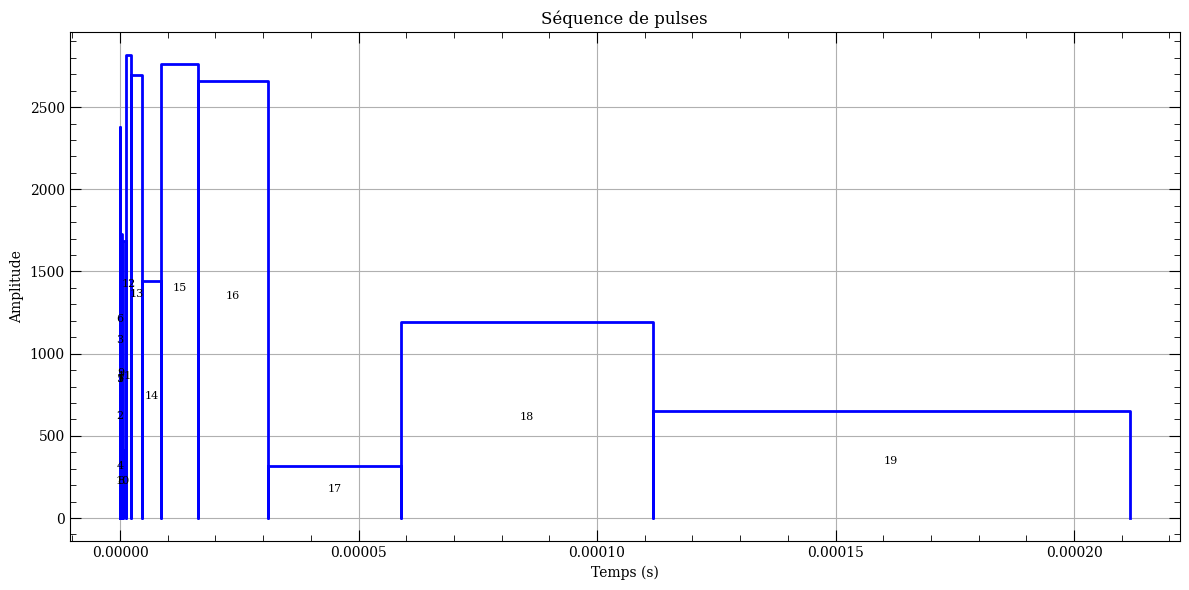

In [3]:
# Création des données pour le graphique
def generate_pulse_data(pulse_list):
    time_points = []
    amplitude_points = []

    current_time = 0

    for amplitude, duration in pulse_list:
        # Point de départ du pulse (montée instantanée)
        time_points.append(current_time)
        amplitude_points.append(0)

        # Sommet du pulse (après montée instantanée)
        time_points.append(current_time)
        amplitude_points.append(amplitude)

        # Maintien de l'amplitude pendant la durée du pulse
        current_time += duration

        # Point avant la descente
        time_points.append(current_time)
        amplitude_points.append(amplitude)

        # Point après la descente (instantanée)
        time_points.append(current_time)
        amplitude_points.append(0)

    return time_points, amplitude_points

# Génération des données
times, amplitudes = generate_pulse_data(pulse_list)

# Création du graphique
plt.figure(figsize=(12, 6))
plt.plot(times, amplitudes, 'b-', linewidth=2)
plt.grid(True)
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Séquence de pulses')

# Mise à l'échelle logarithmique pour l'axe x si nécessaire
# plt.xscale('log')  # Décommentez cette ligne si vous souhaitez une échelle logarithmique

# Ajout d'informations sur les pulses
for i, (amplitude, duration) in enumerate(pulse_list):
    if amplitude > 0:  # Ne pas annoter le dernier pulse avec amplitude 0
        plt.annotate(f'{i+1}',
                     xy=(sum(d for _, d in pulse_list[:i]) + duration/2, amplitude/2),
                     ha='center',
                     fontsize=8)

plt.tight_layout()
plt.show()


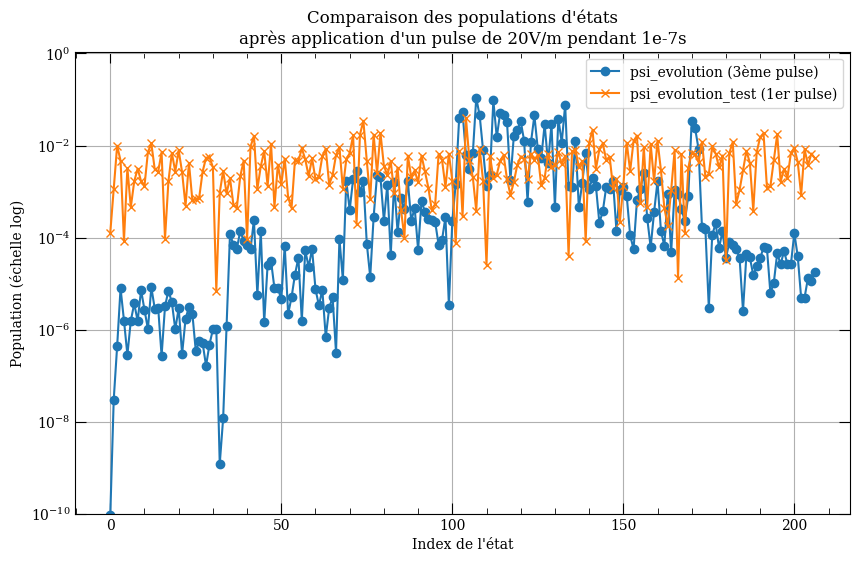

In [4]:
import matplotlib.pyplot as plt
# Création du plot logarithmique
plt.figure(figsize=(10, 6))

# Tracer les populations en échelle logarithmique
plt.semilogy(pop_states[-1], label='psi_evolution (3ème pulse)', marker='o')
plt.semilogy(pop_states_test[-1], label='psi_evolution_test (1er pulse)', marker='x')

# Personnalisation du graphique
plt.xlabel('Index de l\'état')
plt.ylabel('Population (échelle log)')
plt.title('Comparaison des populations d\'états\naprès application d\'un pulse de 20V/m pendant 1e-7s')
plt.grid(True)
plt.legend()

# Ajuster les limites de l'axe y pour mieux voir les petites valeurs
plt.ylim(1e-10, 1.1)

plt.show()

/var/folders/8l/xxl61m252sq_j4xxgx_ll1qr0000gn/T/ipykernel_80281/2030610250.py:18: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axes[i].semilogy(pop,


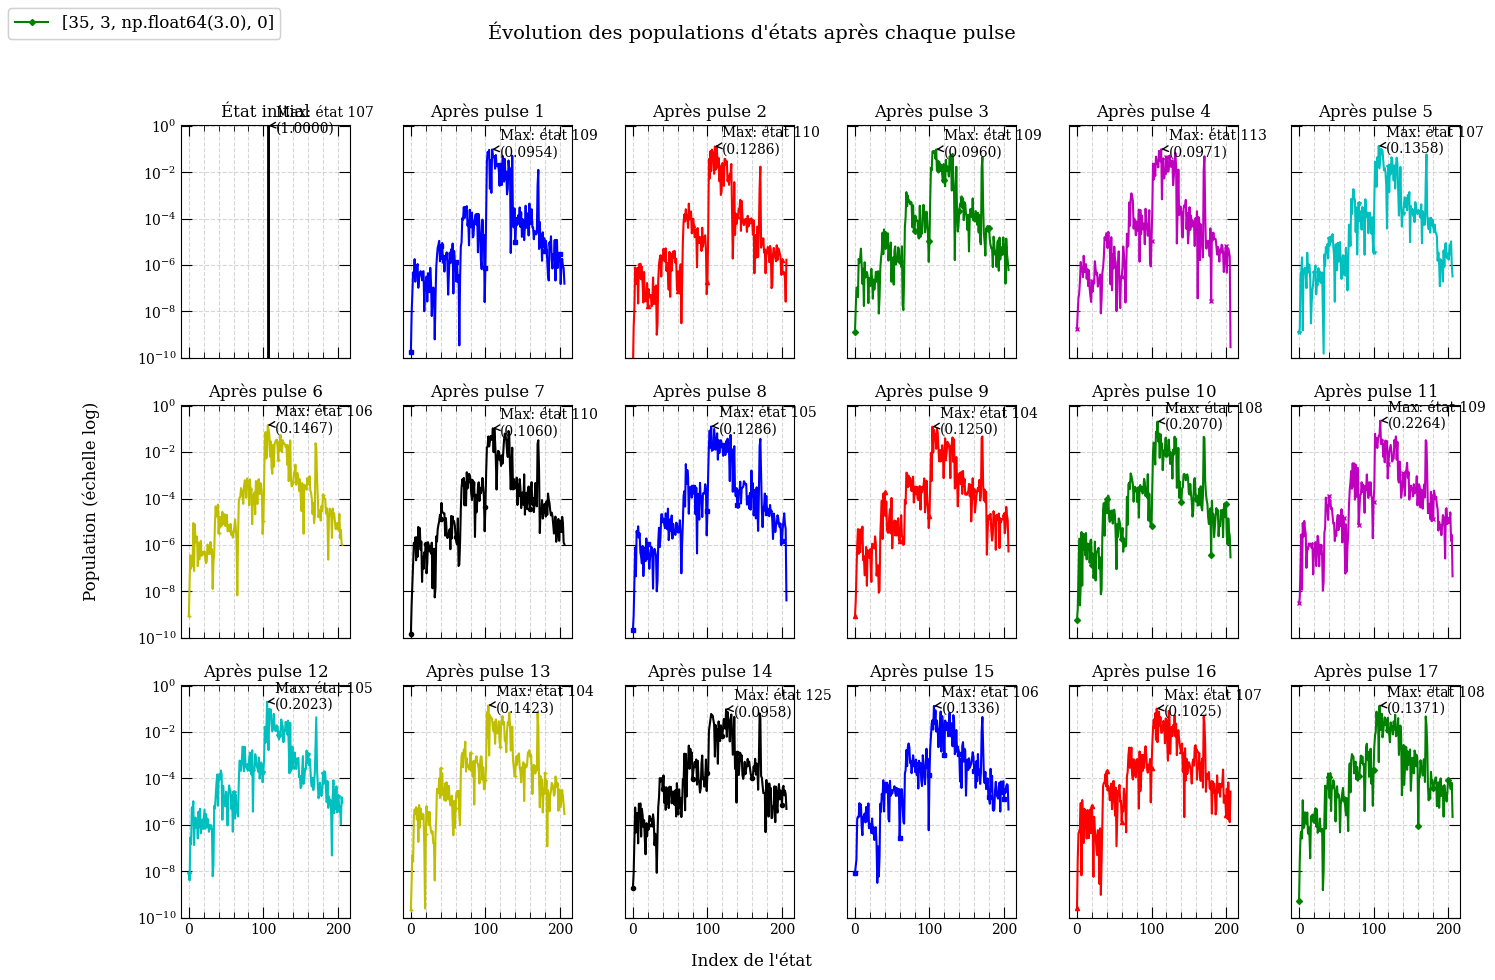

In [5]:
# Définir les couleurs et marqueurs (manquants dans le code précédent)
colors = ['k', 'b', 'r', 'g', 'm', 'c', 'y']
markers = ['o', 's', '^', 'D', 'x', '*', '+']
# Alternative : grille de graphiques
fig, axes = plt.subplots(3, 6, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Tracer chaque pulse dans son propre sous-graphique
for i, pop in enumerate(pop_states):
    if i >= len(axes):
        break
        
    if i == 0:
        title = 'État initial'
    else:
        title = f'Après pulse {i}'
    
    axes[i].semilogy(pop, 
                    color=colors[i % len(colors)], 
                    marker=markers[i % len(markers)],
                    markersize=3, 
                    linestyle='-', 
                    markevery=20,
                    label = calc.basisStates[calc.indexOfCoupledState])
    
    axes[i].set_title(title)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.5)
    axes[i].set_ylim(1e-10, 1.1)
    
    # Ajouter un indicateur du pic principal
    max_idx = np.argmax(pop)
    axes[i].annotate(f'Max: état {max_idx}\n({pop[max_idx]:.4f})',
                   xy=(max_idx, pop[max_idx]),
                   xytext=(max_idx+10, pop[max_idx]*0.5),
                   arrowprops=dict(arrowstyle='->'))

# Ajouter des labels communs
fig.text(0.5, 0.04, 'Index de l\'état', ha='center', va='center', fontsize=12)
fig.text(0.06, 0.5, 'Population (échelle log)', ha='center', va='center', rotation='vertical', fontsize=12)
fig.suptitle('Évolution des populations d\'états après chaque pulse', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', fontsize=12)
"""
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
"""
fig.legend(handles, labels, loc='upper left', fontsize=12)
plt.tight_layout(rect=[0.08, 0.05, 1, 0.95])
plt.show()

/var/folders/8l/xxl61m252sq_j4xxgx_ll1qr0000gn/T/ipykernel_80281/3458175618.py:18: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  axes[i].semilogy(pop,


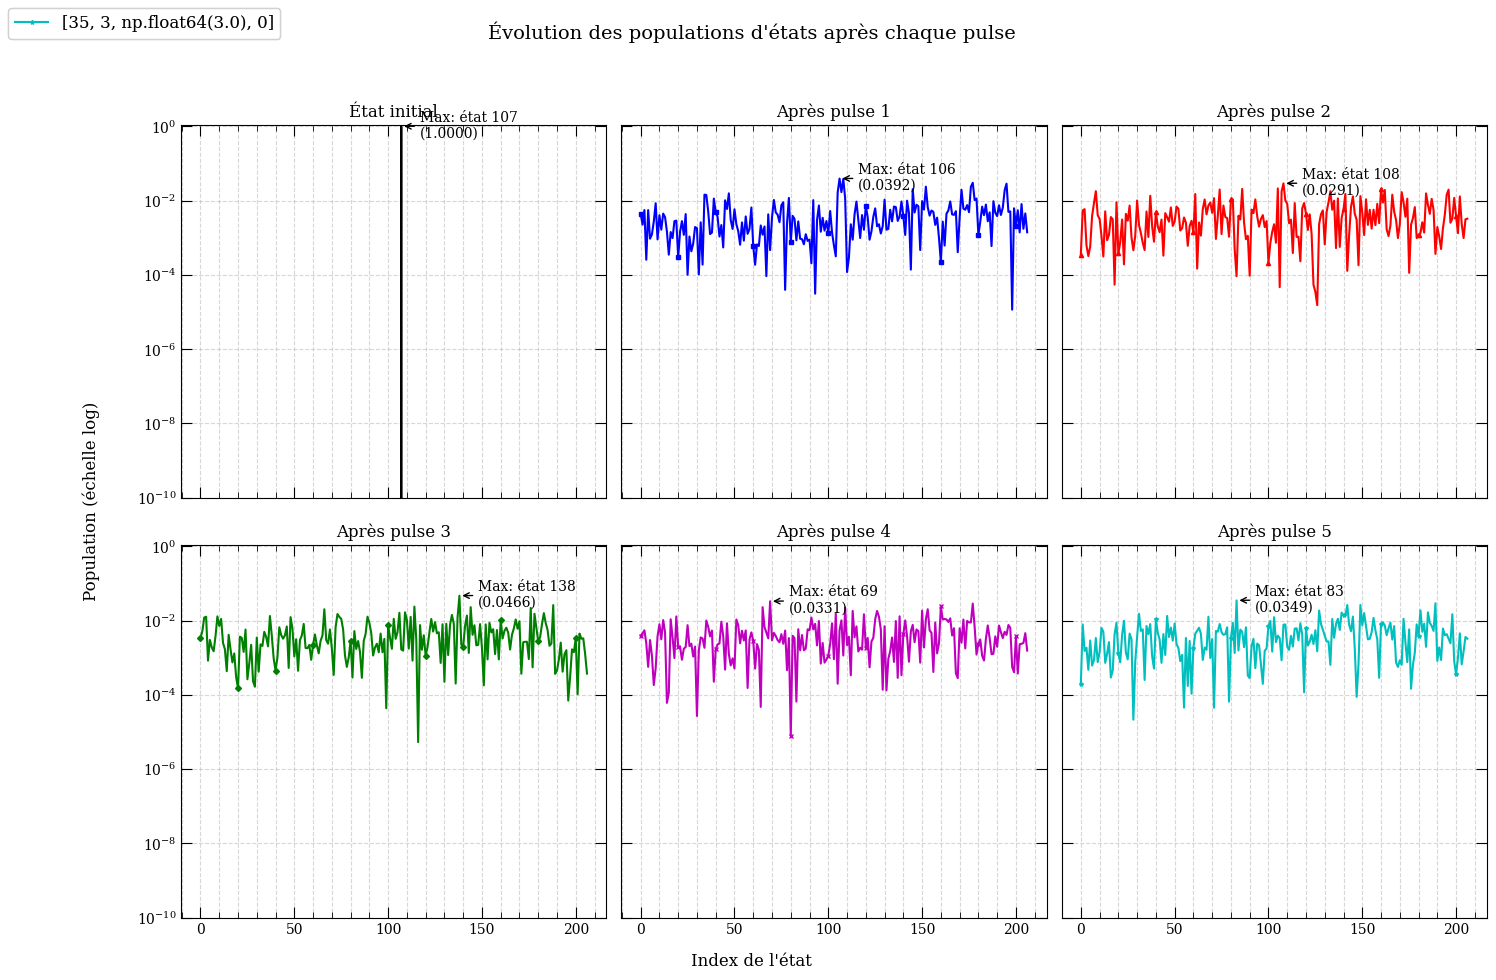

In [6]:
# Définir les couleurs et marqueurs (manquants dans le code précédent)
colors = ['k', 'b', 'r', 'g', 'm', 'c', 'y']
markers = ['o', 's', '^', 'D', 'x', '*', '+']
# Alternative : grille de graphiques
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Tracer chaque pulse dans son propre sous-graphique
for i, pop in enumerate(pop_states_test):
    if i >= len(axes):
        break
        
    if i == 0:
        title = 'État initial'
    else:
        title = f'Après pulse {i}'
    
    axes[i].semilogy(pop, 
                    color=colors[i % len(colors)], 
                    marker=markers[i % len(markers)],
                    markersize=3, 
                    linestyle='-', 
                    markevery=20,
                    label = calc.basisStates[calc.indexOfCoupledState])
    
    axes[i].set_title(title)
    axes[i].grid(True, which='both', linestyle='--', alpha=0.5)
    axes[i].set_ylim(1e-10, 1.1)
    
    # Ajouter un indicateur du pic principal
    max_idx = np.argmax(pop)
    axes[i].annotate(f'Max: état {max_idx}\n({pop[max_idx]:.4f})',
                   xy=(max_idx, pop[max_idx]),
                   xytext=(max_idx+10, pop[max_idx]*0.5),
                   arrowprops=dict(arrowstyle='->'))

# Ajouter des labels communs
fig.text(0.5, 0.04, 'Index de l\'état', ha='center', va='center', fontsize=12)
fig.text(0.06, 0.5, 'Population (échelle log)', ha='center', va='center', rotation='vertical', fontsize=12)
fig.suptitle('Évolution des populations d\'états après chaque pulse', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', fontsize=12)
"""
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
"""
fig.legend(handles, labels, loc='upper left', fontsize=12)
plt.tight_layout(rect=[0.08, 0.05, 1, 0.95])
plt.show()

In [7]:
print_pop_states = np.array(pop_states)
print("\nPopulation du state 35F3 après chaque pulse:", print_pop_states[:,calc.indexOfCoupledState])
print("Population du state 5 après 2ème pulse:", print_pop_states[2, 5])



Population du state 35F3 après chaque pulse: [0.         0.03033342 0.03707519 0.01552225 0.02330516 0.02801396
 0.03269713 0.01571451 0.02207444 0.0093573  0.00976745 0.06171266
 0.01681653 0.07180641 0.01143837 0.00711873 0.0146191  0.00699701
 0.0015561  0.03887283 0.03887283]
Population du state 5 après 2ème pulse: 1.5401251813926973e-07


In [8]:
# Initialiser new_basis avec la même taille que calc.basisStates
new_basis = [None] * len(calc.basisStates)

# Remplir selon l'ordre de index_new_basis
for new_idx, original_idx in enumerate(calc.index_new_basis):
    if 0 <= original_idx < len(calc.basisStates):
        new_basis[new_idx] = calc.basisStates[original_idx]
    else:
        raise IndexError(f"Index {original_idx} invalide pour calc.basisStates de taille {len(calc.basisStates)}")
